# 📚 **Installation**

In [1]:
import bz2
import joblib
import warnings
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.palettes import viridis, cividis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance

warnings.filterwarnings("ignore", category=FutureWarning, module='category_encoders.base_contrast_encoder')
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Create viridis palette
viridis_palette = viridis(256)

# 📂 **Data**

In [2]:
result_df = pd.read_csv("SG.csv")

# **📊 Probability Density**

In [3]:
# Set the parameters of the normal distribution
mean, std = 0, 1  # You can adjust these parameters based on your desired shape

# Generate synthetic data from the normal distribution
resid_scores = result_df['SG']

# Fit the normal distribution to the synthetic data
params = norm.fit(resid_scores)

# Now you can use the parameters for further analysis or generating random samples

# Calculate histogram
hist, edges = np.histogram(resid_scores, density=True, bins=60)

# Generate the x values for the fitted normal distribution
x = np.linspace(min(resid_scores), max(resid_scores), 100)

# Calculate the probability density function for the fitted normal distribution
pdf = norm.pdf(x, *params)

# Create a Bokeh figure
p = figure(height=450, width=600,title=f'Residual Normality \n\nMean: {params[0]:.2f}, Std Dev: {params[1]:.2f}', 
           x_axis_label='Residual Scores', y_axis_label='Density')

# Plot the histogram
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='white', 
       fill_color=viridis_palette[180], alpha=0.9)

# Plot the fitted normal distribution
p.line(x, pdf, line_color=viridis_palette[10], line_width=4, legend_label='Fitted Normal Distribution')
p.x_range.start = -1
p.x_range.end = 1
p.y_range.start = 0

# Show the plot
show(column(p))

# **xS Map**

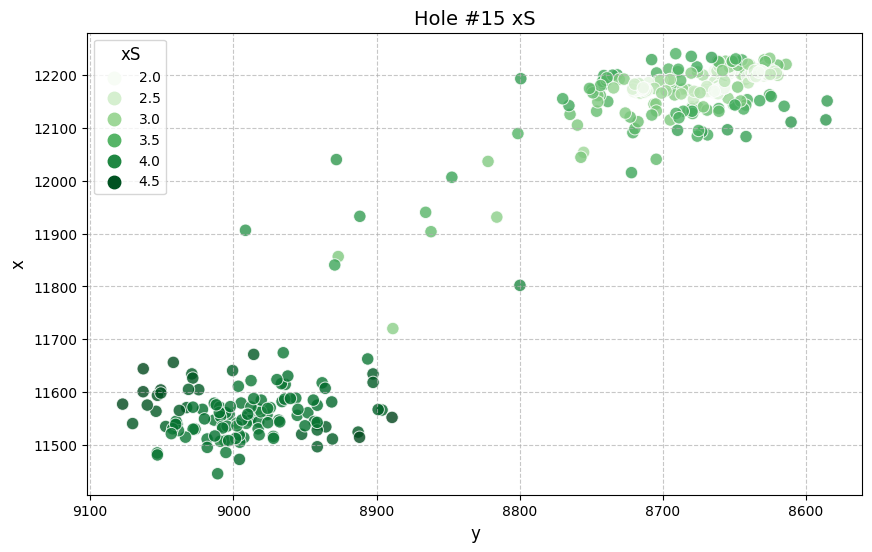

In [4]:
# Filter DataFrame
temp_df = result_df[result_df['hole'] == 15]

temp_df = temp_df[temp_df['x'] != 0]
temp_df = temp_df[temp_df['y'] != 0]
temp_df = temp_df[temp_df['to_location_scorer'] != 'Unknown']

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='y', y='x', alpha=0.8, hue='xS', data=temp_df, palette='Greens', s=80, edgecolor='w')

# Customize the plot
legend = ax.legend(fontsize='10', loc='upper left', title='xS', title_fontsize='12', markerscale=1.5)
ax.invert_xaxis()
ax.set_title('Hole #15 xS', fontsize=14)
ax.set_xlabel('y', fontsize=12)
ax.set_ylabel('x', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [5]:
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '50-100', '100-150', '150-200', '200+']

# Apply binning to the DataFrame
result_df['SG_by_distance'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)

# Fill missing values with empty string
result_df['SG_by_distance'] = result_df['SG_by_distance'].cat.add_categories([''])
result_df['SG_by_distance'].fillna('', inplace=True)

SG_by_distance_series = result_df.groupby(['last_name','SG_by_distance'])['SG'].sum()
SG_by_distance_df = SG_by_distance_series.to_frame().reset_index()
pivoted_df = SG_by_distance_df.pivot(index='last_name', columns='SG_by_distance', values='SG')

new_columns = []
for col in pivoted_df.columns:
    try:
        col_int = int(col)
        new_col_name = f'{col_int - 50}-{col_int + 50}_SG_by_distance'
    except ValueError:
        new_col_name = col  # If conversion fails, keep the original name
    new_columns.append(new_col_name)

pivoted_df.columns = new_columns

# Resetting index to make last_name a column
pivoted_df.reset_index(inplace=True)
pivoted_df.drop(pivoted_df.columns[-1], axis=1, inplace=True)
pivoted_df.rename(columns={'last_name': 'Golfer'}, inplace=True)
new_order = ['Golfer', '200+','150-200','100-150','50-100', '0-50']
pivoted_df = pivoted_df[new_order]

places = {'Haas': 1,
        'Mahan': 2,
        'Donald': 3, 
        'Choi': 3, 
        'Baddeley': 3,
        'Howell III': 6, 
        'Scott': 6, 
        'Day': 6, 
        'Van Pelt': 9, 
        'Mickelson': 10, 
        'Ogilvy': 11, 
        'Bradley': 11, 
        'Woodland': 13, 
        'Dufner': 13, 
        'Stricker': 15, 
        'Singh': 16, 
        'Toms': 16, 
        'Snedeker': 16, 
        'Jacobson': 16, 
        'Rose': 20, 
        'Kuchar': 20, 
        'Simpson': 22, 
        'Johnson': 23, 
        'Watson': 23, 
        'Senden': 25, 
        'Wilson': 26, 
        'Reavie': 26, 
        'Watney': 26, 
        'Yang': 29, 
        'Byrd': 30}

pivoted_df['Finish'] = pivoted_df['Golfer'].map(places)
pivoted_df = pivoted_df.sort_values(by='Finish', ascending=True)

# **SG by Distance**

In [6]:
pivoted_df.style.hide(axis='index')

Golfer,200+,150-200,100-150,50-100,0-50,Finish
Haas,6.320631,0.499898,4.872593,-0.467558,5.485863,1
Mahan,6.587117,0.560316,0.485629,0.390026,5.504923,2
Baddeley,10.963322,-0.465608,5.798767,2.302405,3.489865,3
Choi,2.021851,5.578207,0.370261,-0.272280,2.119587,3
Donald,8.161004,2.648352,2.199902,-0.693151,6.925954,3
Scott,2.198309,4.381052,-0.149259,-0.540725,1.694514,6
Day,3.263358,3.282512,-1.926114,0.104352,6.124342,6
Howell III,3.926055,-2.091013,1.063376,0.173335,5.232756,6
Van Pelt,0.562142,0.366159,0.930431,0.152713,4.496815,9
Mickelson,2.093667,-1.107568,1.787373,-0.607032,4.119346,10


In [7]:
# Assume pivoted_df is your DataFrame
numerical_cols = ["200+", "150-200", "100-150", "50-100", "0-50"]
feature_cols = numerical_cols

X = pivoted_df[feature_cols]
y = pivoted_df['Finish']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=888)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DMatrix and provide feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=feature_cols)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=feature_cols)

# Train an XGBoost model
params = {
    'objective': 'reg:squarederror',
    'random_state': 42
}
model = xgb.train(params, dtrain, num_boost_round=100)

from_location_scorer_df_series = result_df.groupby(['last_name','from_location_scorer'])['SG'].sum()
SG_by_lie_df = from_location_scorer_df_series.to_frame().reset_index()
lies_df = SG_by_lie_df.pivot(index='last_name', columns='from_location_scorer', values='SG')
lies_df.columns = [f'{col}' for col in lies_df.columns]
# Filling NaN values with 0
lies_df.fillna(0, inplace=True)

# Resetting index to make last_name a column
lies_df.reset_index(inplace=True)

lies_df['Bunker'] = lies_df[['Green Side Bunker', 'Fairway Bunker']].sum(axis=1)
lies_df.drop(columns=['Green Side Bunker', 'Fairway Bunker'], inplace=True)

lies_df['Other'] = lies_df[['Bunker','Fringe','Other', 'Unknown','Native Area']].sum(axis=1)
lies_df.drop(columns=['Bunker', 'Fringe','Native Area','Unknown'], inplace=True)

lies_df['Rough'] = lies_df[['Intermediate Rough', 'Primary Rough']].sum(axis=1)
lies_df.drop(columns=['Intermediate Rough', 'Primary Rough'], inplace=True)

lies_df.rename(columns={'last_name': 'Golfer'}, inplace=True)

new_order = ['Golfer', 'Tee Box','Rough','Fairway','Green', 'Other']
lies_df = lies_df[new_order]

lies_df['Finish'] = lies_df['Golfer'].map(places)
lies_df = lies_df.sort_values(by='Finish', ascending=True)


# **SG by Lie**

In [8]:
lies_df.style.hide(axis='index')

Golfer,Tee Box,Rough,Fairway,Green,Other,Finish
Haas,4.101173,-1.421836,7.877405,2.743613,3.411073,1
Mahan,3.565164,2.185572,4.448440,2.427649,0.901188,2
Baddeley,8.067298,5.261644,7.152962,1.024544,0.582304,3
Choi,0.205511,1.979723,4.581612,1.572700,1.478080,3
Donald,4.529865,3.611224,4.614803,3.041849,3.444320,3
Scott,2.139694,0.365198,1.373573,1.301600,2.403825,6
Day,1.597192,-0.109611,4.005169,1.718502,3.637198,6
Howell III,1.624626,1.029243,4.667272,2.107042,-1.123675,6
Van Pelt,-2.278913,-0.630492,6.124296,1.969733,1.323634,9
Mickelson,0.104089,4.938471,-2.599947,3.362210,0.480963,10


In [9]:
# Assume lies_df is your DataFrame
numerical_cols = ["Tee Box", 
                  "Rough", 
                  "Fairway",
                  "Green"]

feature_cols = numerical_cols

X = lies_df[feature_cols]
y = lies_df['Finish']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=888)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DMatrix and provide feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=feature_cols)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=feature_cols)

# Train an XGBoost model
params = {
    'objective': 'reg:squarederror',
    'random_state': 42
}
model_2 = xgb.train(params, dtrain, num_boost_round=100)

# **Course Factors**

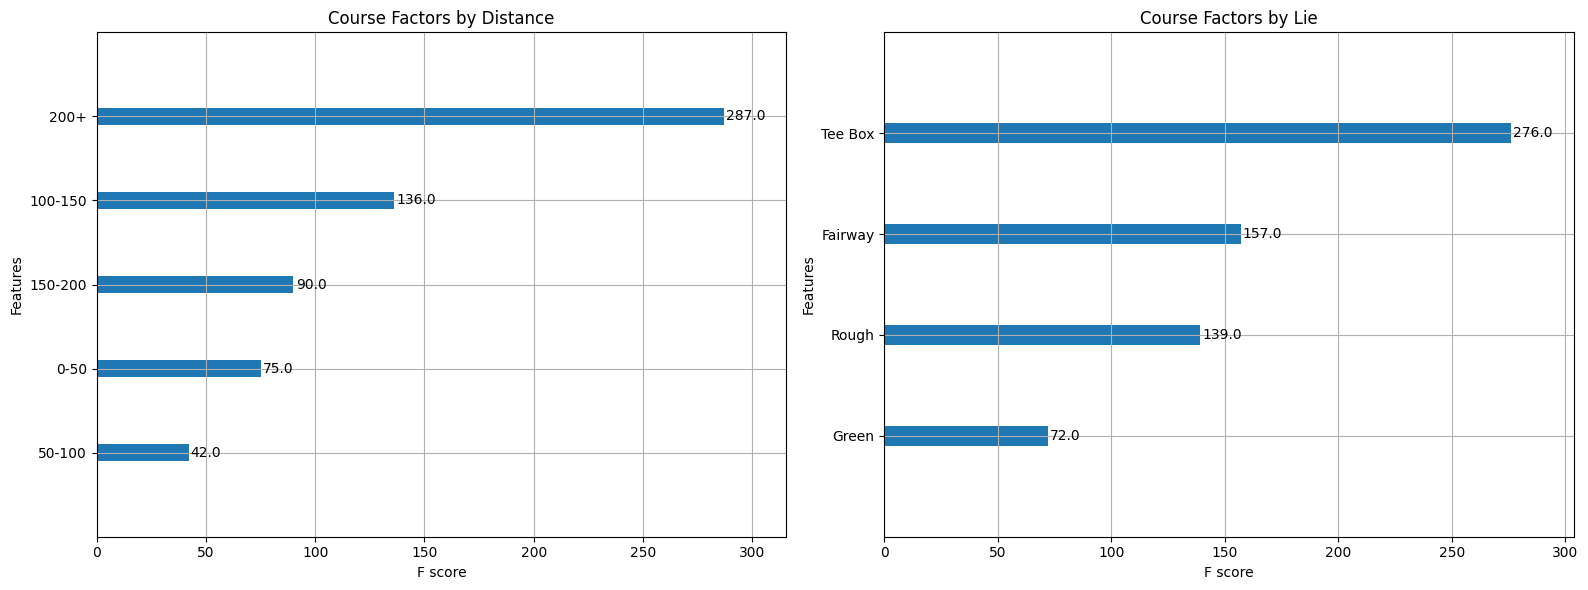

In [10]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot feature importance by distance
plot_importance(model, importance_type='weight', max_num_features=10, ax=axs[0])
axs[0].set_title("Course Factors by Distance")

# Plot feature importance by lie
plot_importance(model_2, importance_type='weight', max_num_features=10, ax=axs[1])
axs[1].set_title("Course Factors by Lie")

# Show the plots
plt.tight_layout()
plt.show()
